<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Side_Objective_IPI_female_bimodal_separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Identify medians in bimodal distributions

This notebook follows Side_Objective_IPI_pipeline. We have confirmed that in some female individuals IPI distribution is indeed bimodal. We plan on generating the density plot in those individuals, find the trough in the plot, and separate the bimodal distribution to find the medians in both distributions. 

Bimodal individuals:
- One in petersii
- Two in poweri

In [3]:
import os
import librosa
import time
import seaborn as sns
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack, signal
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft
import pandas as pd
from scipy.stats import norm, gaussian_kde

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


###Female-male Separation Pipeline

In [ ]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      #((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def write_audio(samples,lowerlimit,upperlimit,points_per_freq,file_name,specific_name,sampling_rate=44100):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  write(file_name+specific_name,sampling_rate,new_sig)

In [ ]:
def separation_for_IPI_calculating(file_path,sampling_rate=44100):
  file_name = os.path.basename(file_path)
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.show()
  
  #obtain female signal
  yf_special = rfft(samples)
  clear_out(boundary_list[1],boundary_list[2],yf_special,points_per_freq)
  female = irfft(yf_special)

  #obtain noise signal
  yf_special = rfft(samples)
  clear_out(boundary_list[0],350,yf_special,points_per_freq)
  noise = irfft(yf_special)

  print('female lower bound: ',boundary_list[1])
  print('female higher bound: ',boundary_list[2])
  return female, noise

###Wave Envelope and Find Peaks

In [ ]:
#get statistics on rapping IPI
def get_rapping_IPI_stats(peak_indices_list,x_time):
  IPI = []
  for i in range(0,len(peak_indices_list)-1):
    front = peak_indices_list[i]
    back = peak_indices_list[i+1]
    difference = x_time[back] - x_time[front]
    IPI.append(difference)
  #Assumption: Rapping is categorized by 3 or more consecutive pulses within 1 second.
  i=0
  IPI_processed = []
  while (i < (len(IPI)-2)):
  #while(0):
    if((IPI[i]+IPI[i+1])<1):
      IPI_processed.append(IPI[i])
      IPI_processed.append(IPI[i+1])
      k = 2
      while(1):
        if((IPI[i+k]<0.5)and(i+k <(len(IPI)-1))):
          IPI_processed.append(IPI[i+k])
          k=k+1
        else:
          i = i+k+1
          break
    else:
      i=i+1
  #generate statistics for rapping IPI plot
  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)

  IPI_processed = [i for i in IPI_processed if (i<median+2*std)]

  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)
  return IPI_processed, mean, median, std

In [ ]:
def IPI_calculation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()

  IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
  print("Mean: ", mean,"; Median: ",median, "; STD: ", std)

###Execution Function

In [ ]:
def female_bimodal_separation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  '''
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()
  '''
  IPI_processed,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
  df = pd.DataFrame (IPI_processed, columns = ['IPI_processed'])
  return df,IPI_processed

####Laevis execution

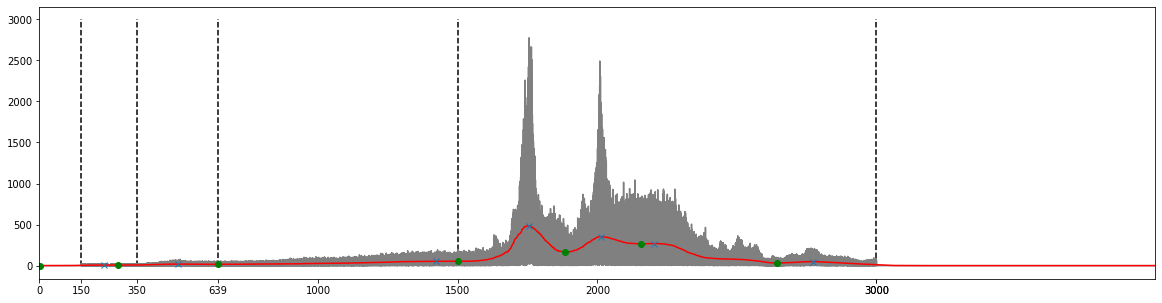

female lower bound:  350.0
female higher bound:  639.490715775107


In [ ]:
#first laevis
file_path='/content/Laevis_01-F818D-F8387-220616_0456_8min_selection.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

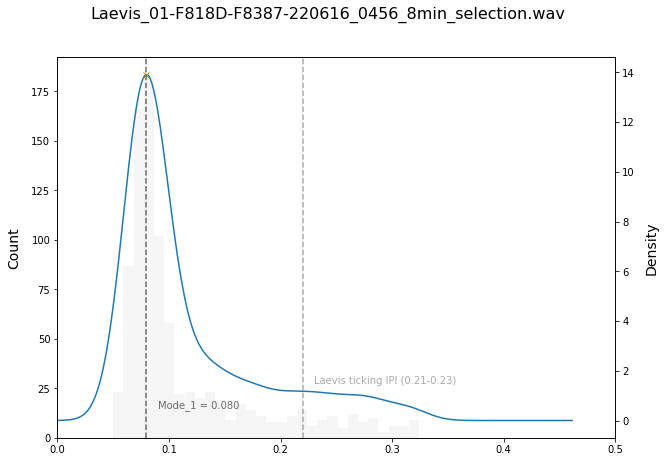

Mode_1:  0.07986571605618831


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
#Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
#ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.22+0.01,1.5,s="Laevis ticking IPI (0.21-0.23)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
#ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.22,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
#print("Median_2: ", Mode_2)

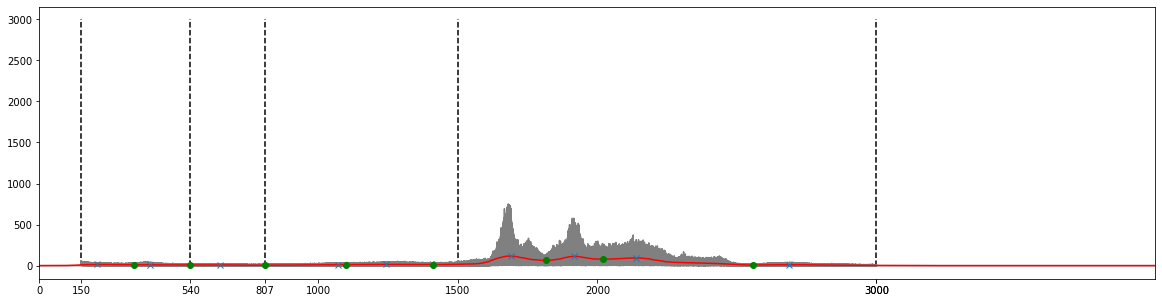

female lower bound:  540.234969715877
female higher bound:  807.3387484532236


In [ ]:
#second laevis
file_path='/content/Laevis_02-F832F-F837D-220616_0456.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

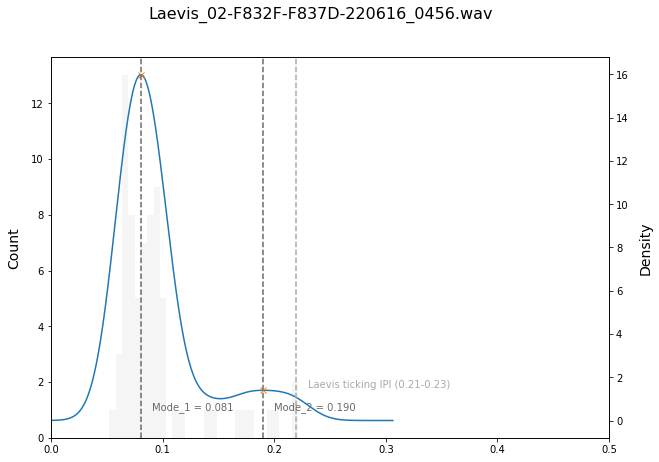

Mode_1:  0.08064247921390451
Mode_2:  0.19011785027657543


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.22+0.01,1.5,s="Laevis ticking IPI (0.21-0.23)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.22,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

####Petersii execution

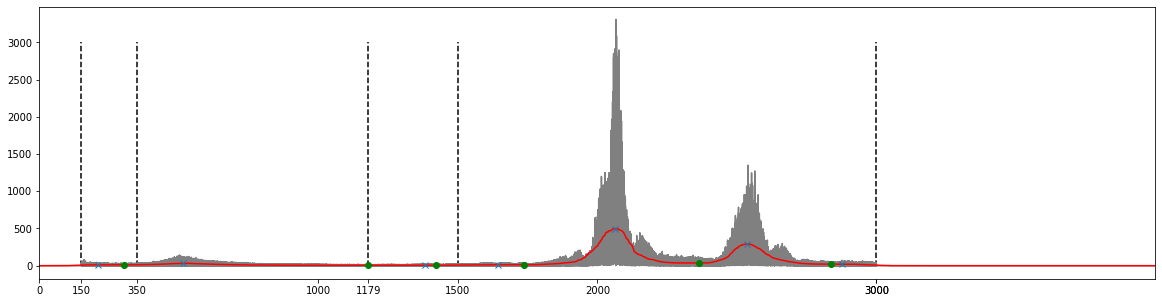

female lower bound:  350.0
female higher bound:  1178.6809924715824


In [ ]:
#first petersii
file_path='/content/Petersii_01-F8244-F8259-220701_0019_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

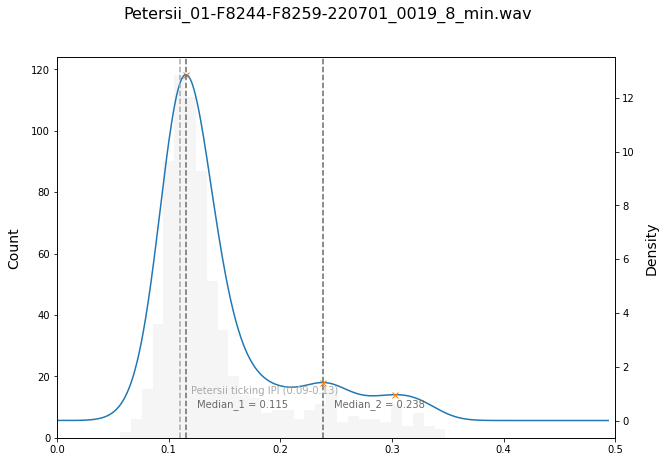

Median_1:  0.11539590611016898
Median_2:  0.23800422871849908


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Median_1 = x[peaks][0]
Median_2 = x[peaks][1]

ax2.text(Median_1+0.01,0.5,s="Median_1 = "+format(Median_1, ".3f"),color='dimgrey')
ax2.text(Median_2+0.01,0.5,s="Median_2 = "+format(Median_2, ".3f"),color='dimgrey')
ax2.text(0.11+0.01,1.0,s="Petersii ticking IPI (0.09-0.13)",color='darkgrey')

ax2.axvline(Median_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Median_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.11,linestyle="dashed",color="darkgrey")

plt.show()

print("Median_1: ", Median_1)
print("Median_2: ", Median_2)

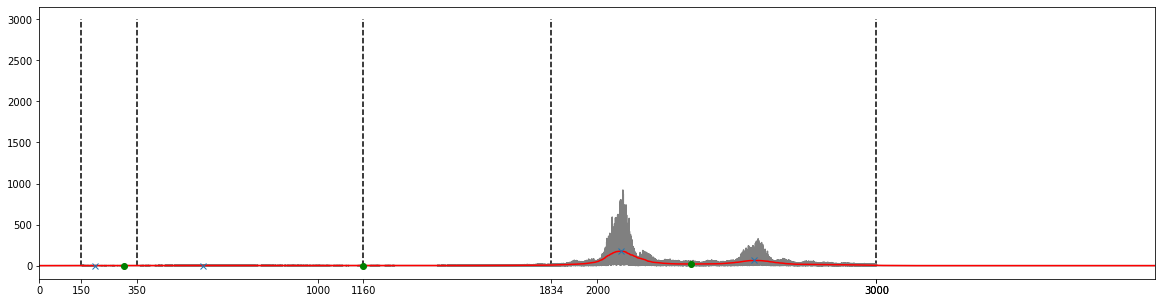

female lower bound:  350.0
female higher bound:  1159.9566685097968


In [ ]:
#third petersii
file_path='/content/Petersii_02-F8212-F821A-220714_1916_1_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

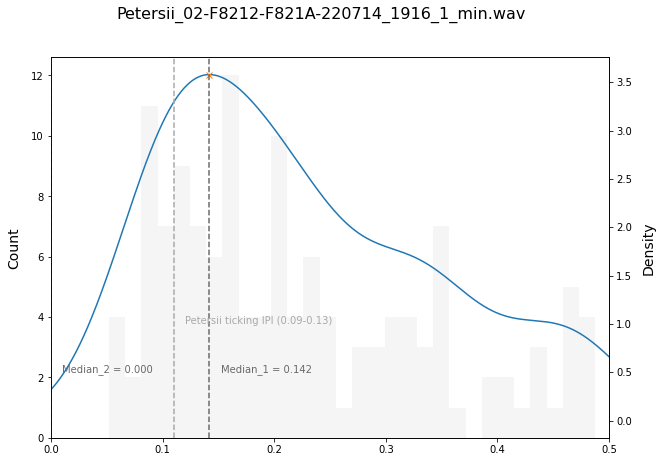

Median_1:  0.14199795033128693
Median_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Median_1 = x[peaks][0]
Median_2 = 0#x[peaks][1]

ax2.text(Median_1+0.01,0.5,s="Median_1 = "+format(Median_1, ".3f"),color='dimgrey')
ax2.text(Median_2+0.01,0.5,s="Median_2 = "+format(Median_2, ".3f"),color='dimgrey')
ax2.text(0.11+0.01,1.0,s="Petersii ticking IPI (0.09-0.13)",color='darkgrey')

ax2.axvline(Median_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Median_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.11,linestyle="dashed",color="darkgrey")

plt.show()

print("Median_1: ", Median_1)
print("Median_2: ", Median_2)

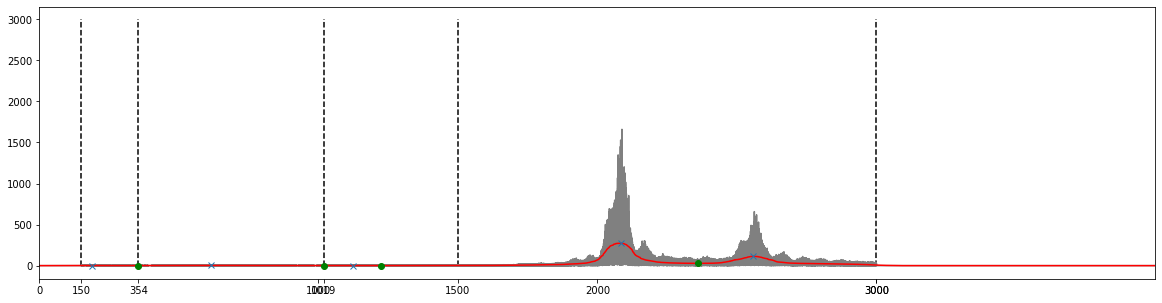

female lower bound:  354.12339961216543
female higher bound:  1018.8778052125454


In [ ]:
#fourth petersii
file_path='/content/Petersii_02-F8212-F829D-220617_0040_4_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

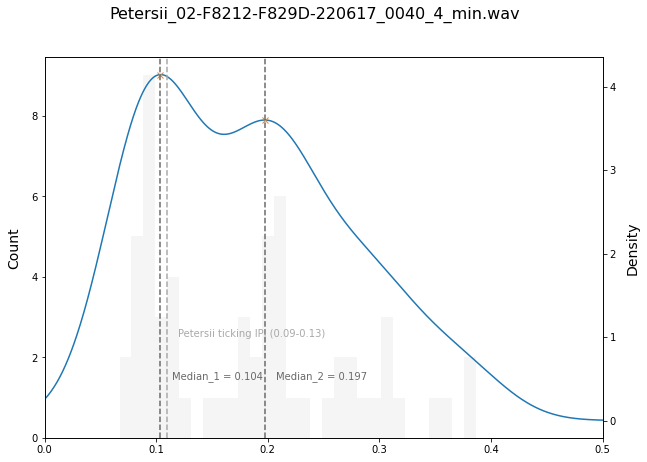

Median_1:  0.1037980270520038
Median_2:  0.19721888555222855


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Median_1 = x[peaks][0]
Median_2 = x[peaks][1]

ax2.text(Median_1+0.01,0.5,s="Median_1 = "+format(Median_1, ".3f"),color='dimgrey')
ax2.text(Median_2+0.01,0.5,s="Median_2 = "+format(Median_2, ".3f"),color='dimgrey')
ax2.text(0.11+0.01,1.0,s="Petersii ticking IPI (0.09-0.13)",color='darkgrey')

ax2.axvline(Median_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Median_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.11,linestyle="dashed",color="darkgrey")

plt.show()

print("Median_1: ", Median_1)
print("Median_2: ", Median_2)

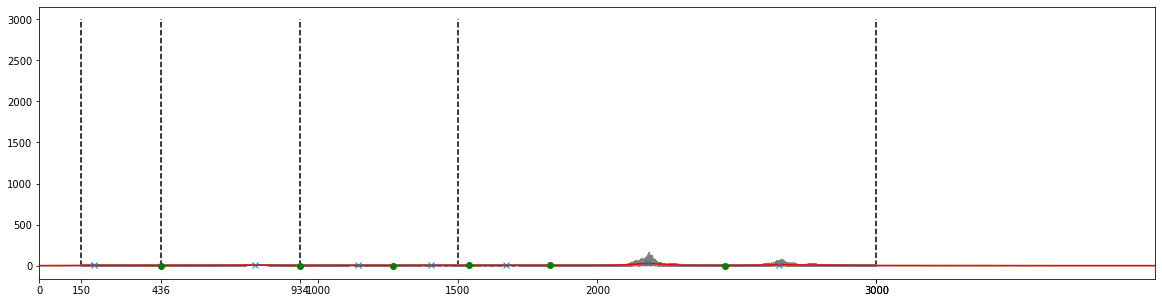

female lower bound:  435.50508140793
female higher bound:  934.0366607611722


In [ ]:
#fifth petersii
file_path='/content/Petersii_02-F8218-F8215-220623_2203_2_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

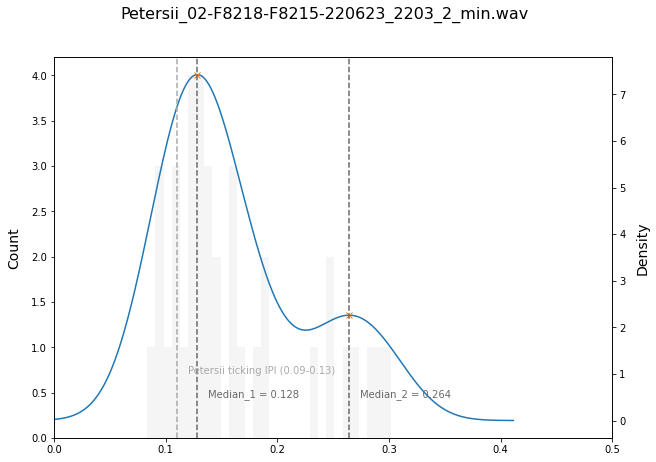

Median_1:  0.12818984517396623
Median_2:  0.2643479533955681


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Median_1 = x[peaks][0]
Median_2 = x[peaks][1]

ax2.text(Median_1+0.01,0.5,s="Median_1 = "+format(Median_1, ".3f"),color='dimgrey')
ax2.text(Median_2+0.01,0.5,s="Median_2 = "+format(Median_2, ".3f"),color='dimgrey')
ax2.text(0.11+0.01,1.0,s="Petersii ticking IPI (0.09-0.13)",color='darkgrey')

ax2.axvline(Median_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Median_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.11,linestyle="dashed",color="darkgrey")

plt.show()

print("Median_1: ", Median_1)
print("Median_2: ", Median_2)

####Vic execution

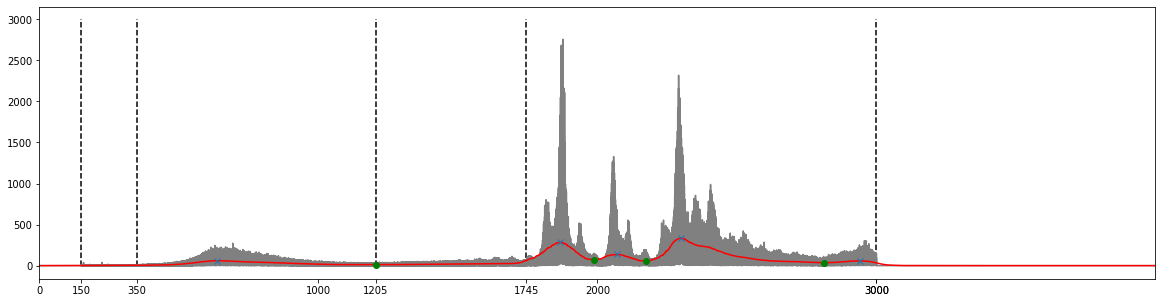

female lower bound:  350.0
female higher bound:  1204.9768075327695


In [ ]:
#first Vic
file_path='/content/Vic_01-AD815-AD7EE-220629_0025_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

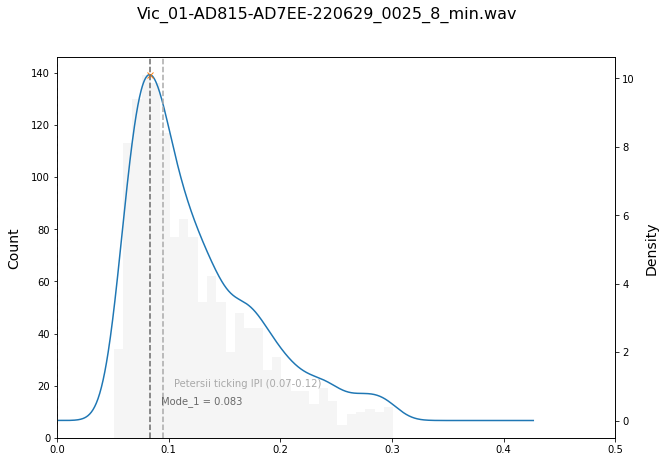

Mode_1:  0.0827917940616085
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = 0#x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
#ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.095+0.01,1.0,s="Petersii ticking IPI (0.07-0.12)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.095,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

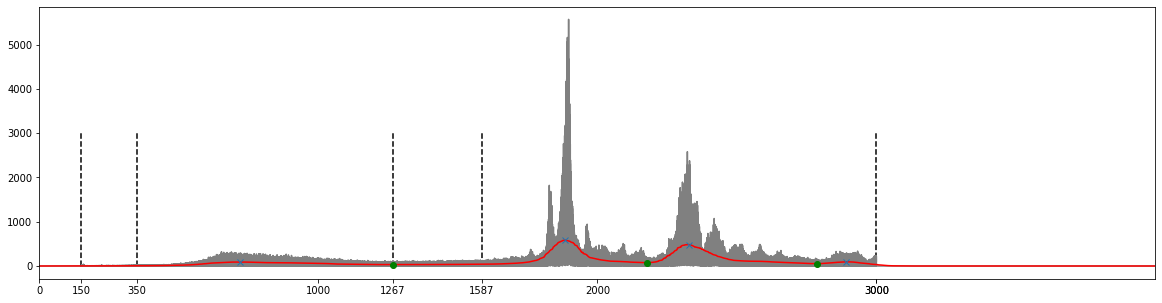

female lower bound:  350.0
female higher bound:  1267.4494587656268


In [ ]:
#second Vic
file_path='/content/Vic_01-AD81A-AD7E7-220630_0036_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

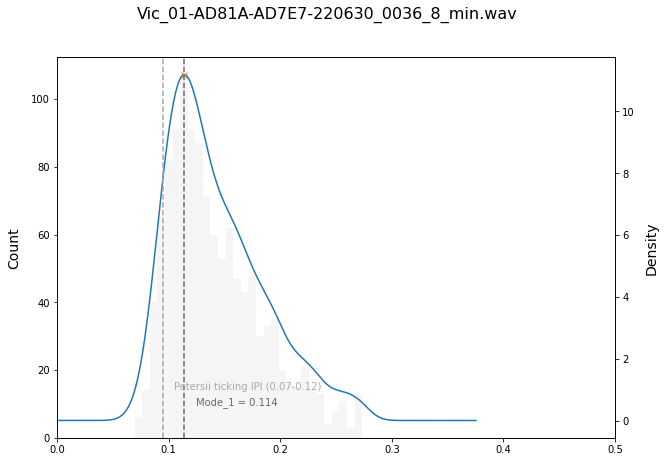

Mode_1:  0.1141057270422291
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = 0#x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
#ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.095+0.01,1.0,s="Petersii ticking IPI (0.07-0.12)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.095,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

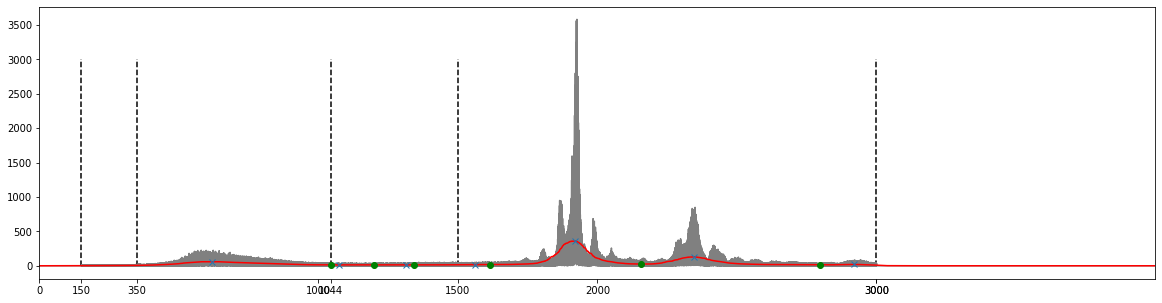

female lower bound:  350.0
female higher bound:  1044.3091421715403


In [ ]:
#third Vic
file_path='/content/Vic_02-AD7D0-AD7DE-220629_0025_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

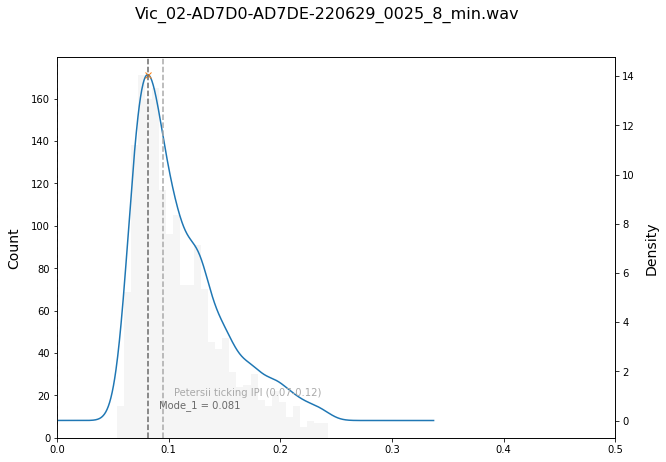

Mode_1:  0.08109311125183664
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = 0#x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
#ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.095+0.01,1.0,s="Petersii ticking IPI (0.07-0.12)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.095,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

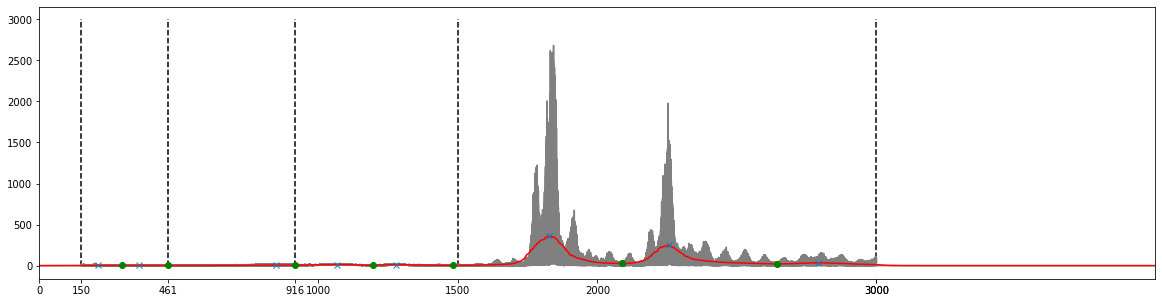

female lower bound:  461.27979046113956
female higher bound:  915.9652655379919


In [ ]:
#fifth Vic
file_path='/content/Vic_02-AD800-AD824-220627_2204_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

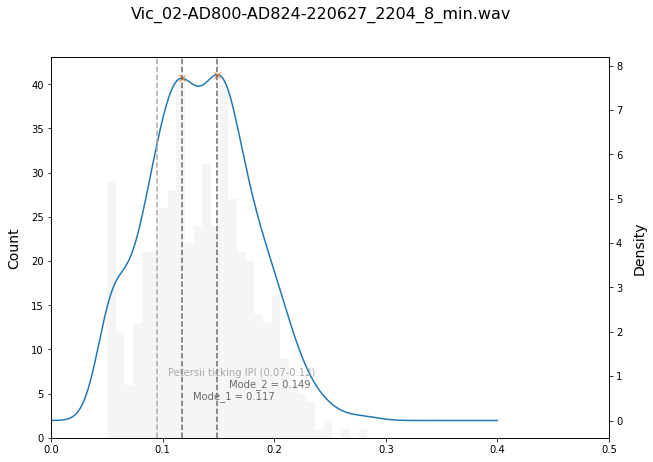

Mode_1:  0.11746165666800232
Mode_2:  0.14922058112533826


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.75,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.095+0.01,1.0,s="Petersii ticking IPI (0.07-0.12)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.095,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

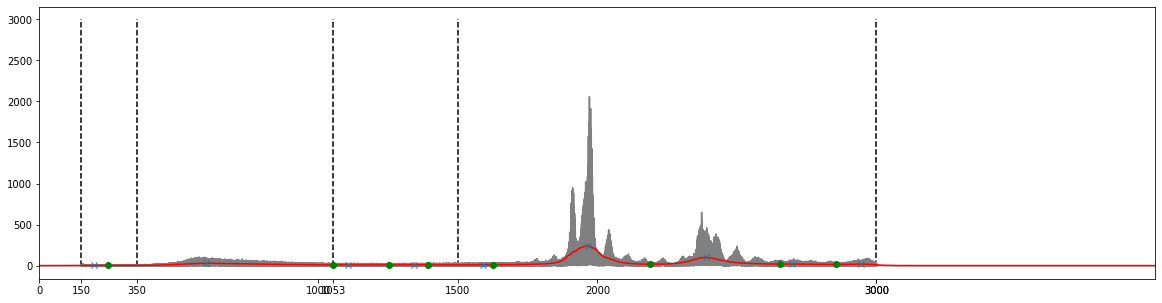

female lower bound:  350.0
female higher bound:  1052.8789996397293


In [ ]:
#sixth Vic
file_path='/content/Vic_03-AD7CA-AD81C-220629_0025_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

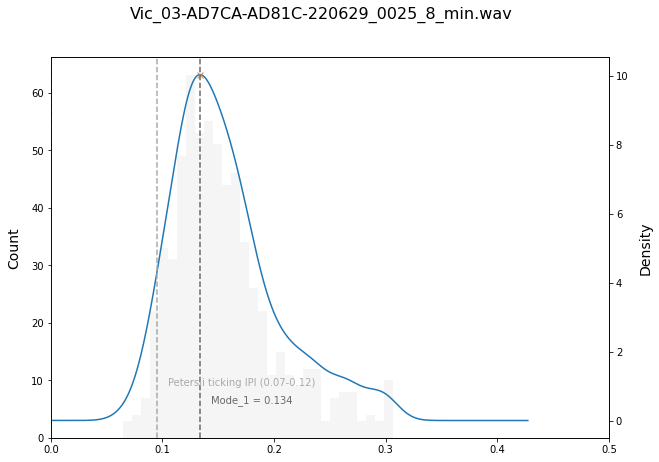

Mode_1:  0.13361395409014512
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = 0#x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
#ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
ax2.text(0.095+0.01,1.0,s="Petersii ticking IPI (0.07-0.12)",color='darkgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
ax2.axvline(0.095,linestyle="dashed",color="darkgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

####Poweri execution



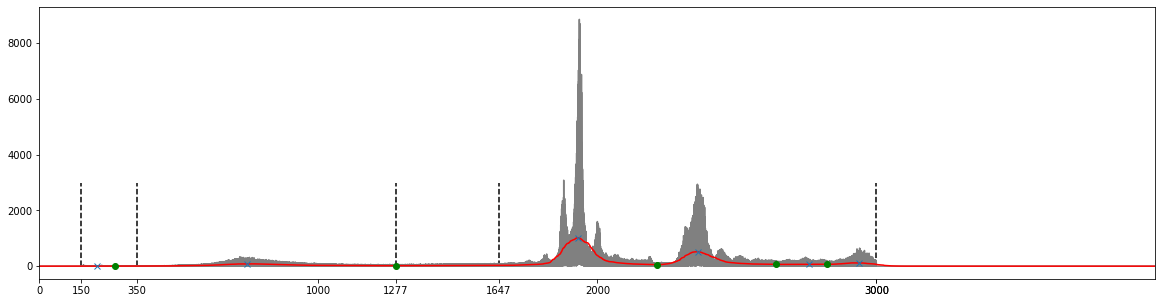

female lower bound:  350.0
female higher bound:  1276.9585267603534


In [ ]:
#first Poweri
file_path='/content/Poweri_01-AD807-AD7EF-220708_0016_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

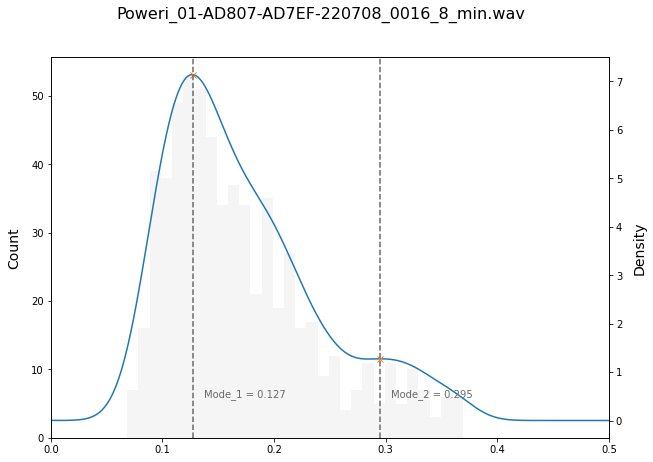

Mode_1:  0.12698265158583807
Mode_2:  0.2952088369548744


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print medians
Mode_1 = x[peaks][0]
Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

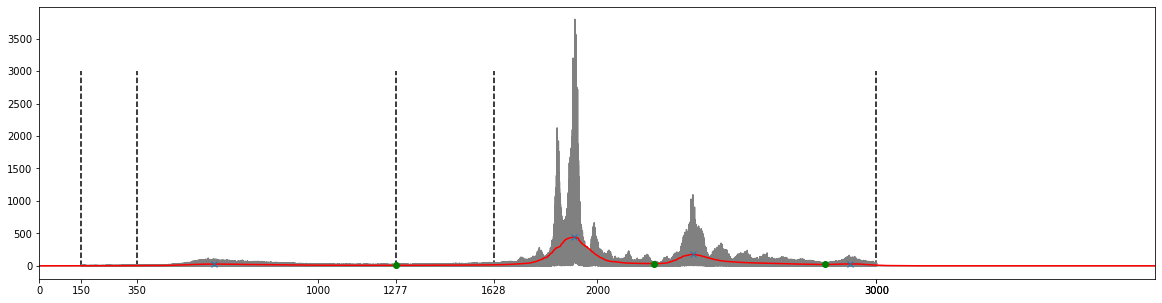

female lower bound:  350.0
female higher bound:  1276.8965765440335


In [ ]:
#second Poweri
file_path='/content/Poweri_02-AD812-AD810-220713_1913_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

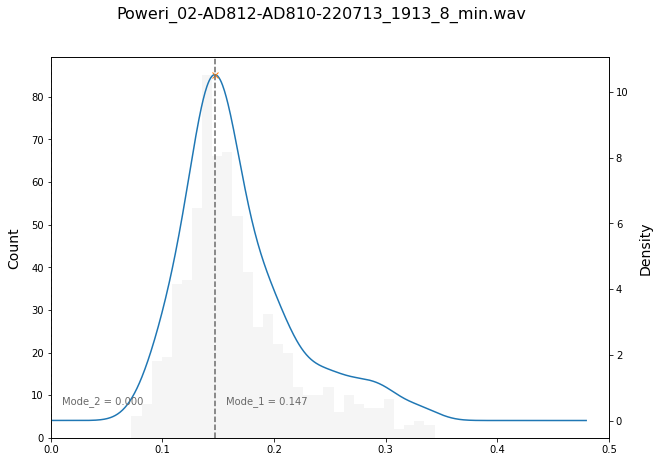

Mode_1:  0.14684980899265837
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print modes
Mode_1 = x[peaks][0]
Mode_2 = 0#[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

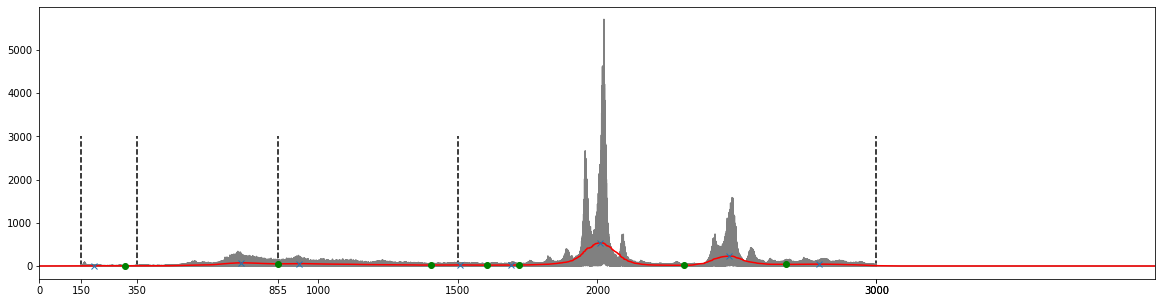

female lower bound:  350.0
female higher bound:  854.5237190290375


In [ ]:
#third Poweri
file_path='/content/Poweri_02-AD826-AD80A-220712_0006_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

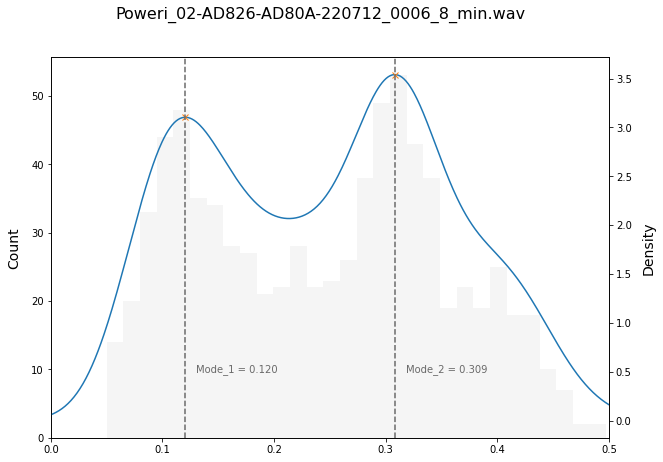

Mode_1:  0.12027631940331773
Mode_2:  0.3085121743058347


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print modes
Mode_1 = x[peaks][0]
Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

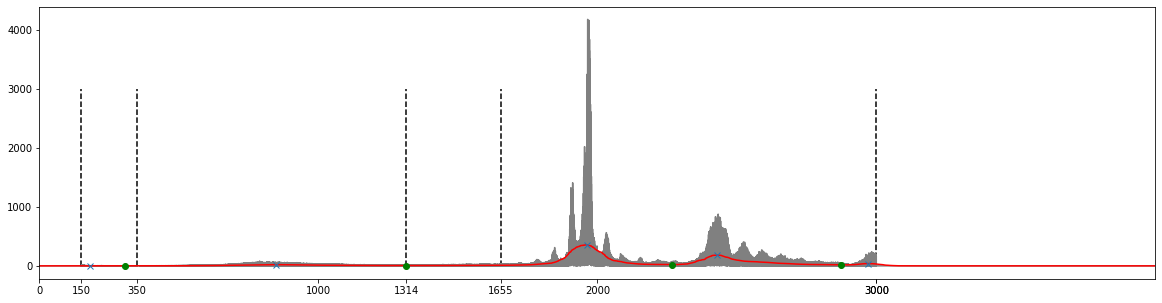

female lower bound:  350.0
female higher bound:  1314.4683771380153


In [ ]:
#fourth Poweri
file_path='/content/Poweri_03-AD82A-AD7CD-220711_2202_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

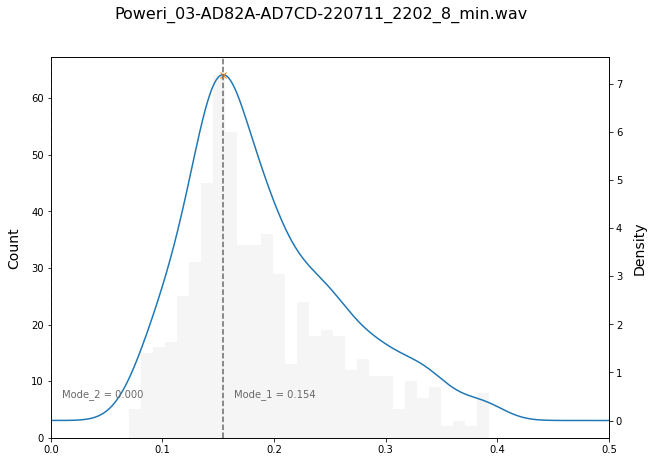

Mode_1:  0.15449105568152932
Mode_2:  0


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print modes
Mode_1 = x[peaks][0]
Mode_2 = 0#x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

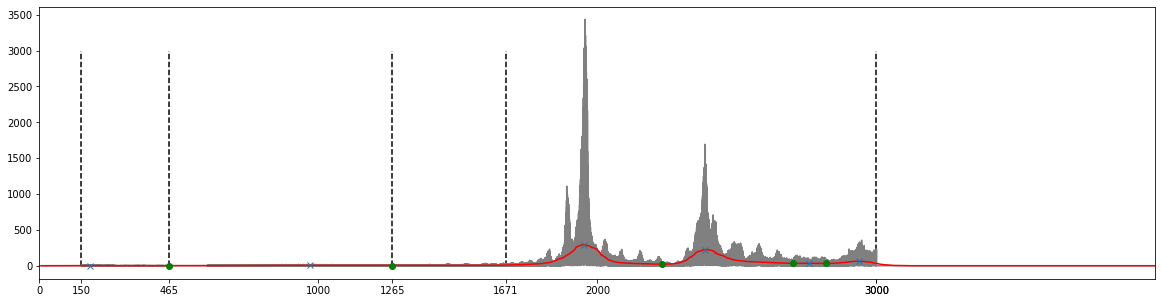

female lower bound:  464.9450865518599
female higher bound:  1265.2683400863982


In [ ]:
#fifth Poweri
file_path='/content/Poweri_03-AD7ED-AD7F8-220713_1913_8_min.wav'
file_name = os.path.basename(file_path)
df, IPI_processed = female_bimodal_separation(file_path)

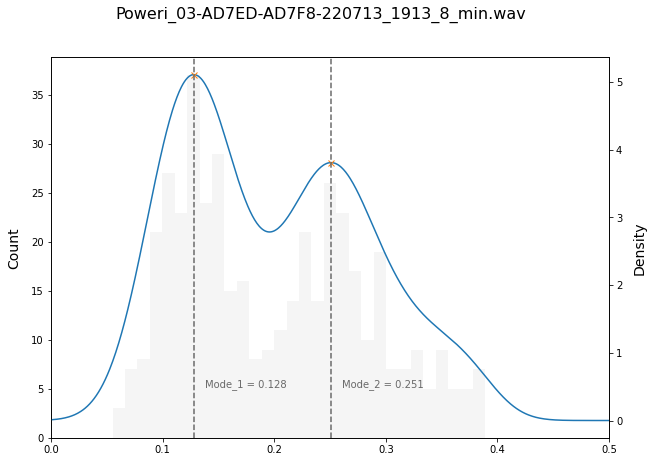

Mode_1:  0.12828532614249544
Mode_2:  0.25068159996732986


In [ ]:
ax = df.plot.kde()
plt.close()
line = ax.lines[0]
x = line.get_xdata()
y = line.get_ydata()

peaks = scipy.signal.find_peaks(y)
peaks = peaks[0]

figure,ax1 = plt.subplots()
figure.suptitle(file_name, fontsize=16)
ax1.hist(IPI_processed,bins=30,color='whitesmoke')
ax1.set_ylabel('Count',fontsize=14,labelpad=10)
ax1.set_xlim(0,0.5)
figure.set_size_inches(10,7)

ax2 = ax1.twinx()

ax2.plot(x,y)
ax2.plot(x[peaks],y[peaks],'x')
ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
ax2.set_ylabel('Density',fontsize=14,labelpad=10)

#print modes
Mode_1 = x[peaks][0]
Mode_2 = x[peaks][1]

ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')

ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")

plt.show()

print("Mode_1: ", Mode_1)
print("Mode_2: ", Mode_2)

###Boxplot

In [4]:
from math import nan
df = pd.DataFrame({'Laevis':[0.08,0.081,nan,nan,nan,nan],
                   'Petersii_mode1':[0.115,0.142,0.104,0.128,nan,nan],
                   'Petersii_mode2':[0.236,0.197,0.259,nan,nan,nan],
                   'Vic':[0.083,0.114,0.081,0.117,0.134,nan],
                   'Poweri_mode1':[0.127,0.147,0.12,0.154,0.128,nan],
                   'Poweri_mode2':[0.295,0.309,0.251,nan,nan,nan]})

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


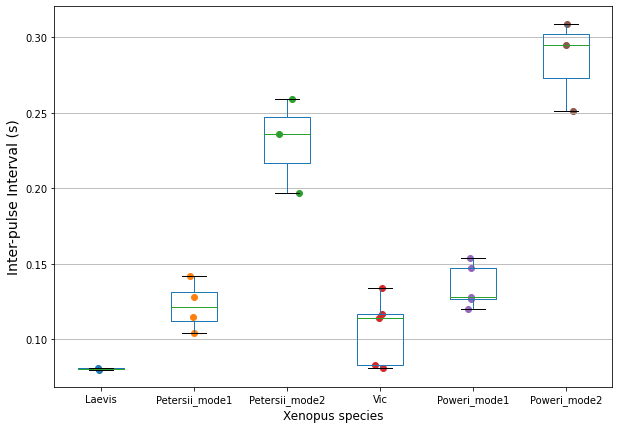

In [5]:
plt.figure(figsize=(10,7))
df.boxplot(grid=False)
for i, d in enumerate(df):
   y = df[d]
   x = np.random.normal(i + 1, 0.04, len(y))
   plt.scatter(x, y)
plt.ylabel('Inter-pulse Interval (s)',fontsize=14)
plt.xlabel('Xenopus species',fontsize=12)
plt.grid(axis='y')
plt.show()